# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [2]:
candidateno=282678


In [3]:

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews


import random


import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [4]:

def split_data(data, ratio=0.7):
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():


    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')


    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)

    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [5]:

random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['"', 'gattaca', '"', 'represents', 'a', 'solid', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [40]:

stop = stopwords.words('english')
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist]
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered
norm_training=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
norm_testing=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in norm_training:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

posdiff=pos_freq_dist-neg_freq_dist

def most_frequent_words(pos_freq,neg_freq,k):
    difference=pos_freq-neg_freq
    sorteddiff=difference.most_common()
    topwords=[word for (word,freq) in sorteddiff[:k]]
    return topwords

pos_wordlist=most_frequent_words(pos_freq_dist,neg_freq_dist,10)
neg_wordlist=most_frequent_words(neg_freq_dist,pos_freq_dist,10)

In [8]:
pos_wordlist

['film',
 'life',
 'also',
 'great',
 'well',
 'world',
 'best',
 'story',
 'many',
 'performance']

In [9]:
neg_wordlist

['bad',
 'movie',
 'plot',
 'even',
 'worst',
 'script',
 'get',
 'could',
 'stupid',
 'nothing']

I prepared text data for sentiment analysis by normalizing and filtering words. Using NLTK, I removed stopwords, converted words to lowercase, and ensured only alphabetical words remained. Then, I generated frequency distributions for normalized words in both training and testing datasets.

Next, I calculated the difference in frequency distributions between positive and negative reviews. To identify the most frequent words associated with each sentiment, I created word lists using the most_frequent_words function.

In summary, I preprocessed and analyzed text data to extract the top 10 most frequent words for both positive and negative sentiments. This process is a common step in building sentiment analysis models, where the frequency of specific words can be indicative of sentiment.

2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [10]:
class SimpleClassifier(ClassifierI):

    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

    def classify(self, doc):

        score = 0


        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value

        return "neg" if score < 0 else "pos"



    def labels(self):
        return ("pos", "neg")

class SimpleClassifier_mf(SimpleClassifier):

    def __init__(self,k):
        self._k=k

    def train(self,training_data):

        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist

        self._pos=most_frequent_words(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=most_frequent_words(neg_freq_dist,pos_freq_dist,self._k)

In [21]:
movieclassifier=SimpleClassifier_mf(10)
movieclassifier.train(norm_training)
testing,goldlabels=zip(*norm_testing)
movieclassifier.classify_many(testing)

['pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',


I created a class called SimpleClassifier for a straightforward sentiment analysis task. In the constructor, I set up word lists for positive and negative sentiments. The classify method evaluates a review's sentiment by scoring the presence of words in these lists. If the score is positive, I classify the review as "pos"; otherwise, it's labeled as "neg." The labels method provides the possible sentiment labels.

Building on that, I extended this class to create a more specialized classifier, WordListClassifier. In its constructor, I added a parameter k to determine the number of top words to consider. The train method processes the training data, calculates frequency distributions for positive and negative reviews, and extracts the most frequent words using the most_frequent_words function. These word lists are then used as features for sentiment analysis.

This approach is a simple yet effective way to create a sentiment classifier based on the most frequent words in positive and negative reviews.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [14]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):

        (self.c1,self.c2)=classes

        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1


    def precision(self):
        p=0

        p = self.TP / (self.TP + self.FP)

        return p

    def recall(self):
        r=0
        r=self.TP/(self.TP+self.FN)

        return r

    def f1(self):
        f1=0

        p=self.precision()
        r=self.recall()
        f1=2*p*r/(p+r)
        return f1

    def accuracy(self):
        a=0
        a=(self.TP+self.TN)/(self.TP+self.FP+self.TN+self.FN)
        return a

In [22]:
evaluate_test=ConfusionMatrix(movieclassifier.classify_many(testing),goldlabels)
evaluate_test.accuracy()

0.66

In [16]:
evaluate_test.precision()

0.6218274111675127

In [17]:
evaluate_test.recall()

0.8166666666666667

In [18]:
evaluate_test.f1()

0.7060518731988472

I designed a class called ConfusionMatrix to assess the performance of a binary classification model. In the constructor, I set up the confusion matrix components (True Positive TP, False Positive FP, False Negative FN, True Negative TN) based on the provided classes, defaulting to "pos" and "neg." I then looped through the predictions and true labels, updating these components accordingly.

For evaluation metrics, I implemented methods to calculate accuracy, precision, recall, and F1 score. The accuracy method gauges the overall correctness of the model, while precision focuses on the accuracy of positive predictions. Recall evaluates the model's ability to capture positive instances. Lastly, the f1 method computes the harmonic mean of precision and recall, providing a balanced measure of the model's performance.

This ConfusionMatrix class is a handy tool for assessing the effectiveness of a binary classification model across various performance metrics



4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

In [24]:
from nltk.classify.api import ClassifierI
import math
class NBClassifier(ClassifierI):

    def __init__(self):

        pass

    def _set_known_vocabulary(self,training_data):
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)

    def _set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors

    def _set_cond_probs(self,training_data):
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1

            conds[label]=classcond

        for label, classcond in conds.items():
            for word in self.known:

                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond

        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}

        self.conds=conds

    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)

    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

In [25]:
myclassifier=NBClassifier()
myclassifier.train(norm_training)
test_nb=ConfusionMatrix(myclassifier.classify_many(testing),goldlabels)

In [26]:
test_nb.accuracy()

0.8333333333333334

In [28]:
test_nb.precision()

0.8378378378378378

In [29]:
test_nb.recall()

0.8266666666666667

In [30]:
test_nb.f1()

0.8322147651006713

I created an NBClassifier class for binary classification using the Naive Bayes algorithm. The class is initialized with methods to establish a known vocabulary, calculate class priors, and compute conditional probabilities during training. The classification process involves computing log probabilities for each class and selecting the class with the highest probability as the prediction. It's important to note that the code lacks an import statement for the random module, which is used in the classify method. Overall, this implementation serves as a basic yet functional Naive Bayes classifier for binary classification tasks.

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


In [37]:
from scipy.stats import siegelslopes
length=[]
accuracy=[]
precision=[]
recall=[]
f1=[]

for i in range(1,30):
    length.append(i)
    result=SimpleClassifier_mf(i)
    result.train(norm_training)
    results=ConfusionMatrix(result.classify_many(testing),goldlabels)
    accuracy.append(results.accuracy())
    precision.append(results.precision())
    recall.append(results.recall())
    f1.append(results.f1())

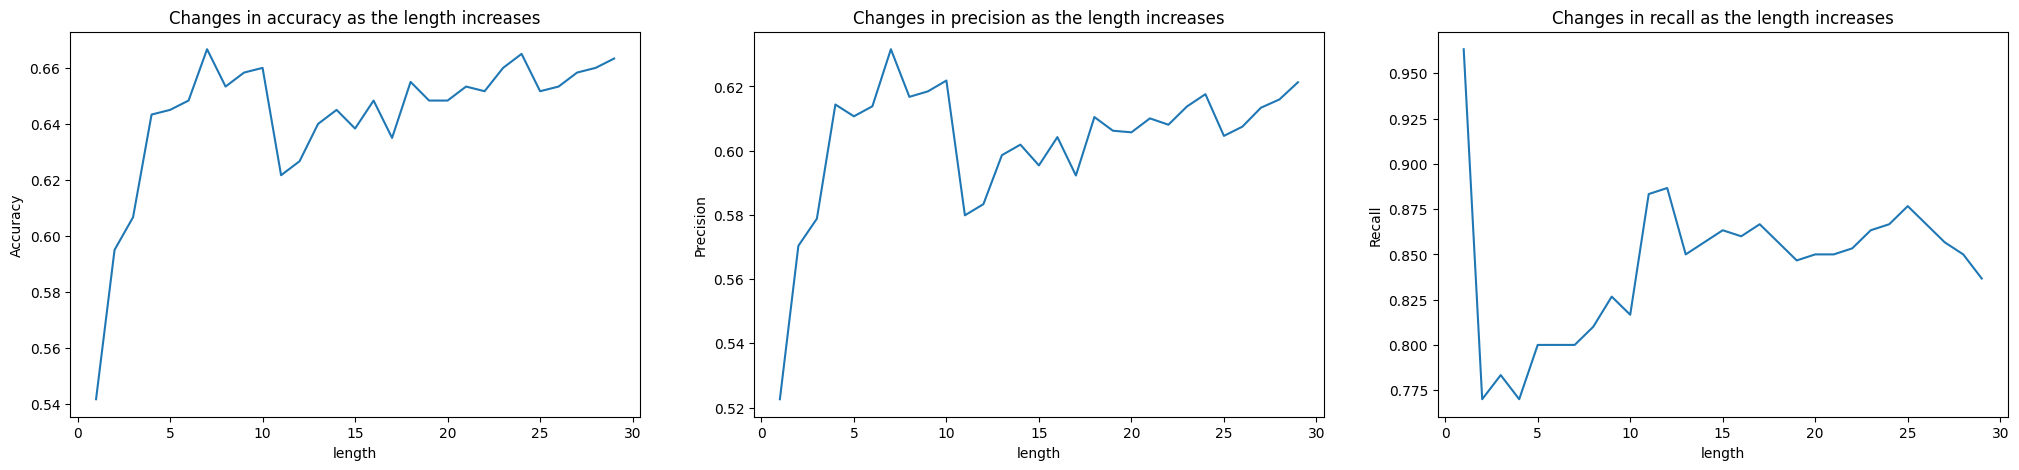

In [38]:
plt.figure(figsize=(25,5))
plt.subplot(1, 3, 1)
plt.plot(length,accuracy)
plt.xlabel("length")
plt.ylabel("Accuracy")
plt.title("Changes in accuracy as the length increases")
plt.subplot(1, 3, 2)
plt.plot(length,precision)
plt.xlabel("length")
plt.ylabel("Precision")
plt.title("Changes in precision as the length increases")
plt.subplot(1, 3, 3)
plt.plot(length,recall)
plt.xlabel("length")
plt.ylabel("Recall")
plt.title("Changes in recall as the length increases")
plt.show()

The recommendation depends on the specific needs of the task. If interpretability and simplicity are crucial, and the wordlist classifier performs well, it might be a suitable choice. However, if the task demands more complex pattern recognition and contextual understanding, a Naive Bayes classifier might be recommended due to its ability to capture relationships between words.
In summary, the choice between a wordlist classifier and a Naive Bayes classifier depends on the experimental results and the specific requirements of the task. If the wordlist classifier exhibits consistent and satisfactory performance across various lengths, it could be recommended. However, a Naive Bayes classifier might be more suitable for tasks requiring advanced contextual understanding and relationship capture.

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/ANLPassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 0
